# 0. 라이브러리 불러오기

이번 실습에서는 **PyTorch** 라는 라이브러리를 사용할 예정입니다!

## 🤔 PyTorch?

PyTorch (이전 이미지 세션에서도 경험했듯이) 딥러닝 모델을 만들고 학습시키는 라이브러리입니다.

PyTorch의 가장 큰 장점 중 하나는 모델의 내부 구조를 한 줄 한 줄 직접 설계할 수 있는 점입니다.

## 💪 실습 과제에서는!

PyTorch에는 `nn.LSTM`이나 `nn.GRU`처럼 이미 완성된 함수를 가져다 사용할 수 있는데요,

이번 실습 과제에서는 RNN, LSTM, GRU의 매커니즘을 직접 구현해보는 것이 목적입니다!

<br>

코드가 다소 길고 복잡해 보일 수 있지만, 모든 줄을 외우거나 당장 완벽하게 이해하실 필요는 전혀 없습니다.

나중에 활용 위주의 과제를 할 때는 Keras라는 라이브러리를 활용해 훨씬 간단하게 할 수 있습니다.

<br>

따라서 이번 실습에서 가장 중요한 것은 # 주석이나 마크다운으로 강조된 핵심 로직을 보면서,

"각 모델(RNN, LSTM, GRU)의 구조가 왜, 그리고 어떻게 다른지"
"그 구조의 차이가 실제 예측 성능에 어떤 영향을 미치는지"

이 두 가지 차이점을 위주로 비교·분석하며 실습해주세요~!

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

import torchvision.transforms as transforms
import torchvision.datasets
from torch.autograd import Variable
from torch.nn import Parameter
from torch import Tensor
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torch.optim as optim
import math

In [ ]:
from datetime import datetime

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

torch.manual_seed(333)

In [ ]:
# gpu 사용
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

cuda = True if torch.cuda.is_available() else False
Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

if torch.cuda.is_available() :
    torch.cuda.manual_seed_all(125)

## 모델의 구조

아래에서 실습하게 될 모델들은 객체지향(OOP) 방식으로 구현되어 있습니다

`class`로 선언된 모델 안에는 `def`로 시작하는 여러 함수(메소드)들이 있습니다.


- `__init__` 함수: 'initialize'(초기화)의 약자입니다. 모델이 처음 생성될 때 필요한 것들(ex: nn.Linear, nn.LSTM 같은 레이어)을 미리 정의하고 준비하는 부분입니다.

- `forward` 함수: 모델의 핵심 로직인 **순전파**를 담당합니다. 데이터(x)가 입력으로 들어왔을 때, `__init__`에서 준비한 레이어들을 어떤 순서로 통과시켜 최종 출력(output)을 만들지 정의합니다.

# 1. Torch 복습

## 1차원 텐서

In [ ]:
t = torch.FloatTensor([0., 1., 2., 3., 4., 5., 6.])

print(t)
print("\n텐서의 차원: \t", t.dim())
print("텐서의 shape: \t", t.shape)
print("텐서의 size: \t", t.size())

tensor([0., 1., 2., 3., 4., 5., 6.])

텐서의 차원: 	 1
텐서의 shape: 	 torch.Size([7])
텐서의 size: 	 torch.Size([7])


In [ ]:
# 인덱싱
print(t[0], t[1], t[-1])

# 슬라이싱
print(t[2:***], t[***:-1])
print(t[:***], t[***:])

tensor(0.) tensor(1.) tensor(6.)
tensor([2., 3., 4.]) tensor([4., 5.])
tensor([0., 1.]) tensor([3., 4., 5., 6.])


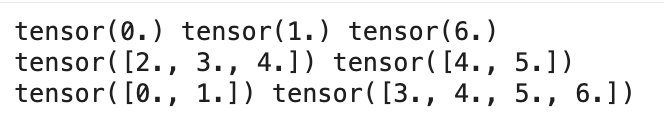

## 2차원 텐서

In [ ]:
t = torch.FloatTensor([[1., 2., 3.],
                       [4., 5., 6.],
                       [7., 8., 9.],
                       [10., 11., 12.]
                      ])
print(t)

tensor([[ 1.,  2.,  3.],
        [ 4.,  5.,  6.],
        [ 7.,  8.,  9.],
        [10., 11., 12.]])


In [ ]:
print(t[:, 1])
print(t[:, 1].****())

tensor([ 2.,  5.,  8., 11.])
torch.Size([4])


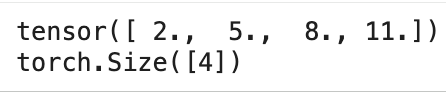

# 2. RNN 실습 - 사인 함수 예측

첫 번째로, 가장 기본적인 RNN 모델을 직접 구현하여 `sin` 함수를 예측하는 실습을 진행합니다.

`sin` 함수는 완벽한 주기를 가진 데이터입니다.

이 실습의 목표는 RNN 모델이 **'이전 시점의 데이터 포인트'**(h_t-1, 은닉 상태)를 **'현재 시점의 입력'**(x_t)과 어떻게 결합하여

**다음 값을 예측**하는지를 알아보고자 합니다.

### 1. 사인함수 생성

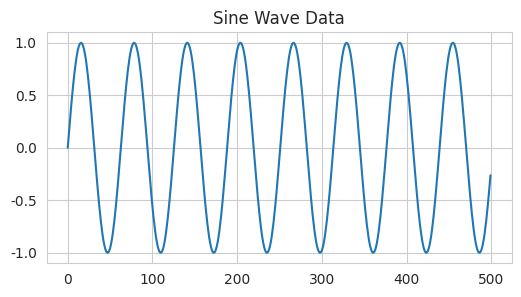

In [ ]:
def generate_sine_wave(seq_length, num_samples):
  x = np.linspace(0, 50, num_samples)
  y = np.sin(x)
  return y

data = generate_sine_wave(seq_length=50, num_samples=500)
plt.figure(figsize=(6,3))
plt.plot(data)
plt.title("Sine Wave Data")
plt.show()

### 2. 시퀀스 클래스 만들기

In [ ]:
def create_sequences(data, seq_length):
    sequences = [] #입력 데이터 시퀀스를 저장한 리스트
    labels = []    #정답 값을 저장할 리스트

    """
    주어진 데이터에서 일정 길이(seq_length)만큼의 연속된 데이터를 입력 시퀀스로 만들고,
    해당 시퀀스 바로 다음 값(y값)을 정답으로 설정하는 코드입니다!
    """
    for i in range(len(data) - seq_length):
        sequences.append(data[i:i+**********]) # seq_length만큼의 데이터를 입력으로 사용
        labels.append(data[i+**********])      # 해당 seq_length의 다음 값을 정답으로 설정


    # 리스트를 NumPy 배열로 변환 후 PyTorch 텐서로 변환
    sequences = torch.tensor(np.array(sequences), dtype=torch.float32).unsqueeze(-1)
    labels = torch.tensor(np.array(labels), dtype=torch.float32)

    return sequences, labels

In [ ]:
# 테스트

X, y = create_sequences(data, seq_length=50)
print(f"X: {X.shape}")
print(f"y: {y.shape}")

X: torch.Size([450, 50, 1])
y: torch.Size([450])


### 3. RNN 클래스 만들기

RNN의 계산식은 다음과 같습니다

<img src="https://wikidocs.net/images/page/22886/rnn_image4_ver2.PNG">

은닉층 $h_t = \tanh(W_{x}x_t + W_{h}h_{t-1} + b)$

출력층 $y_t = f(W_yh_t + b)$

- $h_t$ : 현재 시점(t)의 '기억' (은닉 상태)

- $h_{t-1}$ : 바로 이전 시점(t-1)의 '기억' (은닉 상태)

- $x_t$ : 현재 시점(t)의 '입력' (데이터)

- $W$ : 모델이 학습해야 할 가중치

- $f$ : 비선형 활성화 함수



그리고 LSTM 클래스에는 크게 두 개의 함수가 있습니다.

1. init(초기화) : 모델이 학습해야 할 가중치(W) 와 편향(b) 을 정의하고, 입력·은닉·출력 차원을 설정합니다.
2. forward(순전파) : `forward` 함수에서는 데이터(`x`)가 실제로 모델을 통과하는 과정을 정의합니다. 이 부분이 RNN 동작의 핵심입니다.

이 두 가지 함수가 어떻게 정의되는지를 위주로 실습해주세요!

In [ ]:
class SimpleRNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(SimpleRNN, self).__init__()

        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # num_layers(층 개수)만큼 층 쌓기
        self.layers = nn.ModuleList()

        for i in range(num_layers):
            # 첫 번째 레이어는 input_size -> hidden_size
            # 두 번째 레이어부터는 hidden_size -> hidden_size
            layer_input_size = input_size if i == 0 else hidden_size

            # i2h(input to hidden)와 h2h(hidden to hidden)를 nn.Linear로 정의합니다
            i2h = nn.Linear(layer_input_size, ***********)
            h2h = nn.Linear(***********, ***********)

            self.layers.append(nn.ModuleDict({'i2h': i2h, 'h2h': h2h}))

        # RNN의 활성화 함수
        self.tanh = nn.****()

        # 최종 출력층
        # 마지막 레이어의 hidden_size를 받아 1로 출력
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        device = x.device
        batch_size = x.shape[0]
        seq_len = x.shape[1]

        # h_0(은닉 상태) 초기화
        h_prev_layers = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(device)

        final_layer_outputs = []

        # for loop을 이용해 RNN의 순환부 구현
        # 0 ~ seq_len 시점까지 순환을 반복합니다
        for t in range(*******):

            # (1) 현재 time step의 입력 x_t (batch_size, input_size)
            x_t = x[:, t, :]

            # (2) 현재 time step의 입력을 'current_input'으로 사용
            current_input = x_t

            h_current_layers = []

            # 레이어(깊이)별 반복 (Num Layers)
            # = RNN을 num_layers 개수만큼 깊게 쌓기
            for l in range(self.num_layers):
                h_prev = h_prev_layers[l]

                layer_funcs = self.layers[l]
                i2h = layer_funcs['i2h']
                h2h = layer_funcs['h2h']

                # RNN 계산식!!
                # h_t = tanh( W_ih * x_t + b_ih + W_hh * h_{t-1} + b_hh )
                # i2h(현재 입력)와 h2h(이전 기억)을 더해 tanh 활성화 함수 적용 -> 새로운 h_t를 만듦
                h_next = self.tanh(i2h(current_input) + h2h(h_prev))

                h_current_layers.append(h_next)

                # l번째 레이어의 출력(h_next)이
                # (l+1)번째 레이어의 입력('current_input')이 됨
                current_input = h_next

            # [time step t 종료]
            h_prev_layers = torch.stack(h_current_layers)
            final_layer_outputs.append(h_next)

        # [모든 time step 종료]
        # final_layer_outputs: list of (batch_size, hidden_size) [t=0, t=1, ...]
        # 이것을 텐서로 합치면 다음과 같은 모양이 됩니다: (seq_len, batch_size, hidden_size)
        # 이 텐서를 transpose 하여 다음과 같이 변형해주세요!: (batch_size, seq_len, hidden_size)
        out = torch.stack(final_layer_outputs).*********(0, 1)

        # out: 모든 타임스텝의 출력 ([batch_size, seq_len, hidden_size])
        # h1 h2 h3 .... ht -> ht
        ht = out[:, -1, :] # (batch_size, hidden_size)

        # 최종 예측값(ht) 하나를 반환
        return self.fc(ht) # (batch_size, 1)


### 4. 모델 사용

In [ ]:
# 데이터 생성 및 전처리
seq_length = 50
num_samples = 500
data = generate_sine_wave(seq_length, num_samples)
X, y = create_sequences(data, seq_length)

In [ ]:
# 모델 초기화
input_size = 1
hidden_size = 20
num_layers = 2

# 위에서 만든 SimpleRNN 클래스를 사용해줍니다
model = *********(input_size, hidden_size, num_layers)

In [ ]:
# 손실 함수 & 옵티마이저 설정

import torch.optim as optim

# 손실 함수는 평균제곱오차, 옵티마이저는 아담으로 설정해주세요!
loss_fn = nn.*******()
optimizer = optim.****(model.parameters(), lr=0.001)

In [ ]:
# 모델 학습
epochs = 100

for epoch in range(epochs):
    optimizer.*********() # 초기화
    outputs = model(X)
    loss = loss_fn(outputs.squeeze(), y)
    loss.********() # 역전파
    optimizer.step()

    if epoch % 10 == 0:
        print(f'Epoch [{epoch}/{epochs}], Loss: {loss.item():.4f}')

Epoch [0/100], Loss: 0.5105
Epoch [10/100], Loss: 0.1276
Epoch [20/100], Loss: 0.0381
Epoch [30/100], Loss: 0.0333
Epoch [40/100], Loss: 0.0235
Epoch [50/100], Loss: 0.0200
Epoch [60/100], Loss: 0.0168
Epoch [70/100], Loss: 0.0143
Epoch [80/100], Loss: 0.0124
Epoch [90/100], Loss: 0.0106


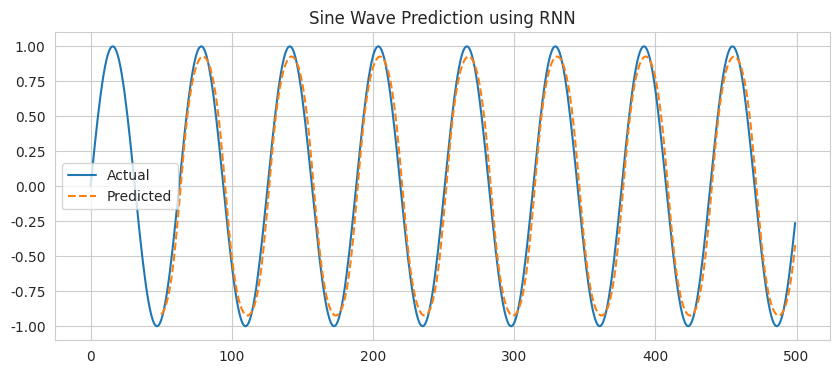

In [ ]:
# 예측 & 시각화
model.eval()
with torch.no_grad():
    predictions = model(X).numpy()

plt.figure(figsize=(10, 4))
plt.plot(data, label='Actual') # 실제 sin 함수
plt.plot(
    range(seq_length, seq_length+len(predictions)),
    predictions,
    label='Predicted',
    linestyle='dashed') # 예측값
plt.legend()
plt.title("Sine Wave Prediction using RNN")
plt.show()

# 4. LSTM / GRU 실습

LSTM/GRU 실습에서는 '삼성전자 주가'라는 실제 데이터를 사용합니다.

RNN 실습과 마찬가지로, 이 복잡한 LSTM과 GRU의 게이트(Gate) 로직을 nn.Linear를 사용해 처음부터 직접 쌓아 올립니다.

두 모델을 동일한 데이터로 학습시킨 뒤, **LSTM과 GRU의 예측 성능이 어떻게 다른지**, 그리고 왜 그런 차이가 발생하는지 코드 상의 '게이트 구조' 를 비교하며 확인해 주세요.

## 데이터 가져오기

yfinance 라이브러리를 이용해 삼성전자의 25년 1월 1일 ~ 25년 5월 31일까지의 주가 데이터를 가져와 주세요!

이 실습에서는 삼성전자 주식의 일별 종가(Close)를 예측할 예정입니다.

In [ ]:
import yfinance as yf

In [ ]:
df = yf.download('005930.KS', # 005930 : 삼성전자 주가
                     start='2025-01-01',
                     end='2025-05-31')

df.head()

/tmp/ipython-input-3511874039.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download('005930.KS', # 005930 : 삼성전자 주가
[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,005930.KS,005930.KS,005930.KS,005930.KS,005930.KS
Date,,,,,
2025-01-02,52526.632812,52723.361774,51444.623522,51838.081446,16630538
2025-01-03,53510.281250,54198.832663,51936.449449,51936.449449,19318046
2025-01-06,54985.746094,55280.839543,53411.914363,53510.278846,19034284
2025-01-07,54493.921875,56362.846993,54493.921875,55871.024594,17030235
2025-01-08,56362.847656,56559.576618,53805.371148,53903.735629,26593553


<Axes: xlabel='Date'>

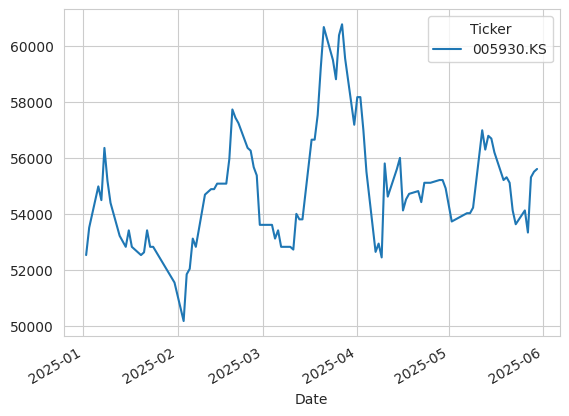

In [ ]:
# 예측하게 될 종가(Close) 살펴보기

df['*****'].plot()

### X, y 데이터 분리

In [ ]:
X = df.****('Close', axis=1) # y변수(종가)를 제외한 칼럼이 X변수가 됩니다
y = df[['Close']]

### 변수 스케일링

In [ ]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

ms = MinMaxScaler()
ss = StandardScaler()

X_ss = ss.fit_transform(X)
y_ms = ms.fit_transform(y)

def create_sequences(data_x, data_y, seq_length):
    sequences = []
    labels = []

    for i in range(len(data_x) - seq_length):
        # i부터 (i + seq_length - 1) 까지의 데이터
        sequences.append(data_x[i:i+**********])
        # (i + seq_length) 날의 종가
        labels.append(data_y[i+seq_length])

    sequences = torch.tensor(np.array(sequences), dtype=torch.float32)
    labels = torch.tensor(np.array(labels), dtype=torch.float32)
    return sequences, labels

seq_length = 10 # 10일치의 데이터를 보고 다음 날을 예측
X_ss_t, y_ms_t = create_sequences(X_ss, y_ms, seq_length)

print(f"Original data length: {len(X_ss)}")
print(f"New sequence X shape: {X_ss_t.shape}")
print(f"New sequence y shape: {y_ms_t.shape}")

Original data length: 99
New sequence X shape: torch.Size([89, 10, 4])
New sequence y shape: torch.Size([89, 1])


In [ ]:
train_size = 79 - seq_length

X_train_tensors_f = X_ss_t[:train_size]
X_test_tensors_f = X_ss_t[train_size:]

y_train_tensors = y_ms_t[:train_size]
y_test_tensors = y_ms_t[train_size:]


print('Training Shape:', X_train_tensors_f.shape, y_train_tensors.shape)
print('Testing Shape:', X_test_tensors_f.shape, y_test_tensors.shape)

Training Shape: torch.Size([69, 10, 4]) torch.Size([69, 1])
Testing Shape: torch.Size([20, 10, 4]) torch.Size([20, 1])


## LSTM (Long Short-Term Memory)

<image src='https://cdn.dida.do/new-project-3-1-1024x607-1024x585.webp'>
LSTM은 '게이트(Gate)'라는 장치를 통해 정보를 선별적으로 잊거나 기억합니다. RNN과 달리 $h_t$ (은닉 상태) 외에 $c_t$ (셀 상태)라는 별도의 '기억 저장소'를 가집니다.

Forget Gate ($f_t$): '이전 정보($c_{t-1}$)'를 얼마나 잊을지 결정.

Input Gate ($i_t$): '새로운 정보($\tilde{c}_t$)'를 얼마나 기억할지 결정.

Output Gate ($o_t$): '현재 기억($c_t$)'을 얼마나 밖으로 보여줄지($h_t$) 결정.

$c_t = (f_t \odot c_{t-1}) + (i_t \odot \tilde{c}_t)$
$h_t = o_t \odot \tanh(c_t)$


### 🤔 LSTM 말고 RNN으로 하면 되는 거 아닌가요?

RNN은 sin 함수처럼 단순하고 짧은 패턴은 잘 기억하지만, 데이터가 복잡해지고 '오래 전'의 정보를 '현재'까지 기억해야 할 때(예: 30일 전의 가격 정보가 오늘 예측에 중요할 때) 그 기억을 잃어버리는 '장기 의존성 문제(Long-Term Dependency Problem)' 가 있습니다.

이 문제를 해결하기 위해 LSTM과 GRU가 등장했습니다.

### RNN 간단하게 예측 모델링해보겠습니다! (비교용)

Epoch [10/100], Loss: 0.199666
Epoch [20/100], Loss: 0.164632
Epoch [30/100], Loss: 0.130894
Epoch [40/100], Loss: 0.097841
Epoch [50/100], Loss: 0.066037
Epoch [60/100], Loss: 0.038401
Epoch [70/100], Loss: 0.020622
Epoch [80/100], Loss: 0.015160
Epoch [90/100], Loss: 0.014082
Epoch [100/100], Loss: 0.012507


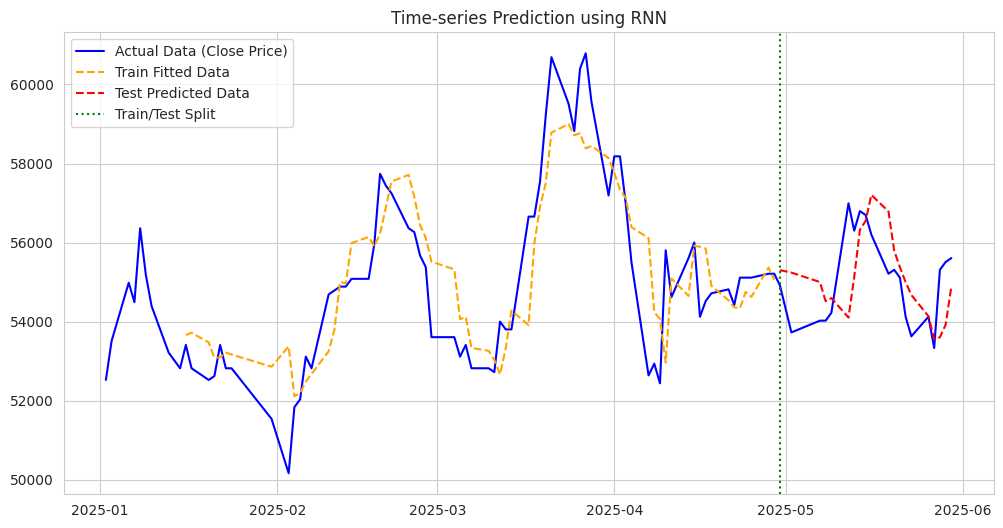

In [ ]:
# 실행만 해주세요!

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
torch.manual_seed(125)
if torch.cuda.is_available() : torch.cuda.manual_seed_all(125)

class RNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(RNNModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.rnn = nn.RNN(input_size, hidden_size, num_layers,
                          batch_first=True, nonlinearity='tanh')

        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        output, hn = self.rnn(x, h_0)
        out = output[:, -1, :]
        out = self.fc(out)
        return out

input_size = 4
hidden_size = 64
num_layers = 1
num_classes = 1
num_epochs = 100
lr = 0.0001

model = RNNModel(input_size, hidden_size, num_layers, num_classes).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

X_train_tensors_f = X_train_tensors_f.to(device)
y_train_tensors = y_train_tensors.to(device)
X_test_tensors_f = X_test_tensors_f.to(device)
y_test_tensors = y_test_tensors.to(device)

for epoch in range(num_epochs) :
    outputs = model(X_train_tensors_f)
    optimizer.zero_grad()
    loss = criterion(outputs, y_train_tensors)
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.6f}')

model.eval()
with torch.no_grad():
    train_predict = model(X_train_tensors_f).cpu().numpy()
    test_predict = model(X_test_tensors_f).cpu().numpy()

train_predicted = ms.inverse_transform(train_predict)
test_predicted = ms.inverse_transform(test_predict)

actual_close = df['Close'].values
train_pred_plot = np.empty_like(actual_close)
train_pred_plot[:] = np.nan
train_pred_plot[seq_length : train_size + seq_length] = train_predicted

test_pred_plot = np.empty_like(actual_close)
test_pred_plot[:] = np.nan
test_pred_plot[train_size + seq_length :] = test_predicted

plt.figure(figsize=(12, 6))
plt.plot(df.index, actual_close, label='Actual Data (Close Price)', color='blue')
plt.plot(df.index, train_pred_plot, label='Train Fitted Data', color='orange', linestyle='--')
plt.plot(df.index, test_pred_plot, label='Test Predicted Data', color='red', linestyle='--')
plt.axvline(x=df.index[train_size + seq_length], c='green', linestyle=':', label='Train/Test Split')
plt.title('Time-series Prediction using RNN')
plt.legend()
plt.show()

예측이 올바르게 되지 않은 게 보이시나요?

지금은 어느 정도의 추세만 따르는 정도이고, 실제 데이터와 차이가 나는 것을 알 수 있습니다!

지금은 간단한 데이터이지만, 데이터가 좀 더 복잡해지면 RNN 성능은 더 낮아지게 되어 이 대신 LSTM/GRU를 사용하게 됩니다

그럼 이제 다시 LSTM으로 돌아가 모델을 만들어보겠습니다

### LSTM 모델 준비

In [ ]:
class MyLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, batch_first=True):
        '''
        input_size : 입력 피처의 차원 (시가, 고가, 저가, 거래량으로 총 4개)
        hidden_size : 은닉 상태의 차원
        num_layers : 쌓아 올릴 LSTM 레이어의 수
        # batch_first = True : 입력 텐서의 첫 번째 차원을 배치 크기로 (batch, seq, feature)
        '''

        super(MyLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.batch_first = batch_first
        self.layers = nn.ModuleList() # 가중치 저장을 위한 변수

        # num_layers 만큼 반복하여 LSTM 레이어를 생성합니다
        for i in range(num_layers):
            # 첫 레이어는 input_size, 이후 레이어는 hidden_size
            current_input_size = input_size if i == 0 else hidden_size

            # LSTM의 4개 게이트(Forget, Input, Gate, Output) 가중치를 정의합니다
            # 1. Input-to-Hidden 가중치 (W_i)
            self.layers.append(nn.Linear(current_input_size, 4 * self.hidden_size))
            # 2. Hidden-to-Hidden 가중치 (W_h)
            self.layers.append(nn.Linear(self.hidden_size, 4 * self.hidden_size))

    def forward(self, x, init_states=None):
        """
        x: (batch_size, seq_len, input_size) (batch_first=True 기준)
        init_states: (h_0, c_0) - 초기 은닉 상태와 셀 상태
        """
        device = x.device

        # batch_first=True (입력이 [batch, seq, feature])인 경우
        # (batch_size, seq_len, input_size) -> (seq_len, batch_size, input_size)로
        # lstm 내부 연산 루프가 수행되도록 변경해줍니다
        if self.batch_first:
            batch_size, seq_len, _ = x.shape
            x = x.*********(0, 1)
        else:
            # 입력이 [seq, batch, feature]인 경우 그대로
            seq_len, batch_size, _ = x.shape

        # 초기 은닉 상태(h_0)와 셀 상태(c_0) 설정
        if init_states is None:
            # init_state가 주어지지 않은 경우 0텐서 생성
            h_prev_layers = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(device)
            c_prev_layers = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(device)
        else:
            # init_state가 주어지면 해당 값을 사용
            h_prev_layers, c_prev_layers = init_states

        last_layer_outputs = []

        # 시간 단계(Time Step)별 반복
        for t in range(seq_len):
            # 현재 time step의 입력 x_t
            # (batch_size, input_size)
            x_t = x[t, :, :]

            current_input = x_t

            # 현재 time step t에서 각 레이어의 (h_t, c_t)를 저장할 리스트
            h_current_layers = []
            c_current_layers = []

            # 레이어(깊이)별 반복
            for l in range(self.num_layers):
                # l번째 레이어의 (t-1) 시점 은닉/셀 상태
                h_prev = h_prev_layers[l]
                c_prev = c_prev_layers[l]

                # l번째 레이어의 가중치
                i2h = self.layers[l*2]
                h2h = self.layers[l*2 + 1]

                # LSTM 계산 (게이트 계산)
                # (W_i * x_t) + (W_h * h_{t-1})
                # l=0일 때 current_input은 x_t, l>0일 때는 (l-1) 레이어의 h_t
                gates = i2h(current_input) + h2h(h_prev)

                # 4개의 게이트로 분리 (f, i, g, o)
                # (batch_size, 4 * hidden_size) -> 4 x (batch_size, hidden_size)
                f_t, i_t, g_t, o_t = torch.chunk(gates, 4, dim=1)

                # 게이트 활성화 함수 적용
                # f/i/o 게이트는 시그모이드, g 게이트는 tanh 활성화 함수를 적용해주세요!

                # (f) Forget Gate: 잊을 부분 결정
                f_t = torch.*****(f_t)
                # (i) Input Gate: 기억할 부분 결정
                i_t = torch..*****(i_t)
                # (g) Gate(Candidate) Gate: 새로운 정보(후보)
                g_t = torch.*****(g_t)
                # (o) Output Gate: 출력할 부분 결정
                o_t = torch.*****(o_t)

                # 셀 상태 및 은닉 상태 업데이트
                # (c_t) Cell State: (잊을 부분 * 이전 상태) + (기억할 부분 * 새 정보)
                c_t = (*** * c_prev) + (i_t * ***)
                # (h_t) Hidden State: (출력할 부분 * tanh(새 셀 상태))
                h_t = o_t * torch.****(c_t)
                # ---------------------------------------

                # 현재 time step t의, l번째 레이어 (h_t, c_t) 저장
                h_current_layers.append(h_t)
                c_current_layers.append(c_t)

                # l번째 레이어의 출력(h_t)이 (l+1)번째 레이어의 입력(current_input)이 됨
                current_input = h_t

            # (time step t 종료)
            # 다음 time step (t+1)의 (h_prev, c_prev)로 사용됨
            h_prev_layers = torch.stack(h_current_layers) # (num_layers, batch_size, hidden_size)
            c_prev_layers = torch.stack(c_current_layers) # (num_layers, batch_size, hidden_size)

            # 마지막 레이어의 은닉 상태(h_t)를 outputs에 저장
            last_layer_outputs.append(h_t) # h_t는 (batch_size, hidden_size)

        # (모든 time step 종료)
        # out 텐서 생성 (nn.LSTM과 동일한 출력)
        # torch.stack -> (seq_len, batch_size, hidden_size)
        out = torch.stack(last_layer_outputs)

        if self.batch_first:
            # (seq_len, batch_size, hidden_size) -> (batch_size, seq_len, hidden_size)
            out = out.transpose(0, 1)

        # 최종 'out' 텐서와, 마지막 time step의 (h_n, c_n) 반환
        return out, (h_prev_layers, c_prev_layers)

In [ ]:
class SimpleLSTM(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length):
        '''
        num_classes: 최종 출력 개수 (주가 1개 예측이므로 1)
        input_size: 입력 피처 개수 (시가, 고가, 저가, 거래량 = 4)
        hidden_size: LSTM 은닉 상태의 차원
        num_layers: 쌓아 올릴 LSTM 레이어 수
        seq_length: 시퀀스 길이 (참고용, 모델 구조에 직접 쓰이진 않음)
        '''
        super(SimpleLSTM, self).__init__()
        self.num_classes = num_classes # 클래스
        self.num_layers = num_layers # LSTM 계층 개수
        self.input_size = input_size  # 입력 크기(컬럼 개수)
        self.hidden_size = hidden_size # 은닉층의 뉴런 개수
        self.seq_length = seq_length # 시퀀스 길이

        # 모듈을 사용할 경우 MyLSTM 대신 nn.LSTM을 사용해주면 됩니다!
        # 이번 실습에서는 위에서 사용한 MyLSTM을 사용해주세요
        self.lstm = ******(input_size=input_size, hidden_size=hidden_size,
                               num_layers=num_layers, batch_first=True)

        self.fc_1 =  nn.Linear(hidden_size, 128) # 완전연결층
        self.fc = nn.Linear(128, num_classes) # 출력층

        self.relu = nn.ReLU() # 활성화 함수

    def forward(self,x):
        # x의 크기 = (num_layers, batch_size, hidden_size)

        # 은닉 상태, 셀 상태 초기화
        h_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        # output: 모든 시점의 (마지막 레이어) 은닉 상태
        # hn: 마지막 시점의 은닉 상태
        # cn: 마지막 시점의 셀 상태
        output, (hn, cn) = self.lstm(x, (h_0, c_0)) # lstm 계층에 은닉 상태와 셀 상태 적용

        hn_last_layer = hn.view(-1, self.hidden_size)

        # 완결연결층과 활성화 함수를 통과시킵니다!
        out = self.relu(hn_last_layer)
        out = self.fc_1(out)
        out = self.relu(out)
        out = self.fc(out)
        return out

In [ ]:
# 하이퍼파라미터를 정의해줍니다

num_epochs = 500
lr = 0.0001

input_size=4
hidden_size=64
num_layers=1

num_classes=1

# 위에서 정의한 SimpleLSTM 클래스를 모델로 정의해줍니다
model = **********(num_classes, input_size, hidden_size, num_layers, X_train_tensors_f.shape[1])

In [ ]:
# 평가 기준과 옵티마이저를 정의해줍니다

# 위와 동일하게 평균제곱오차로 평가, 옵티마이저는 Adam으로 설정해주세요
criterion = torch.nn.*******()
optimizer = torch.optim.****(model.parameters(), lr=lr)

In [ ]:
# 모델 데이터를 gpu로 이동

model = model.to(device)

X_train_tensors_f = X_train_tensors_f.to(device)
y_train_tensors = y_train_tensors.to(device)
X_test_tensors_f = X_test_tensors_f.to(device)
y_test_tensors = y_test_tensors.to(device)

### 모델 학습/예측

In [ ]:
for epoch in range(num_epochs) :
    outputs = model.forward(X_train_tensors_f)

    optimizer.zero_grad()

    loss = criterion(outputs, y_train_tensors)

    # 역전파 수행
    loss.********()

    optimizer.step()
    if epoch % 100 == 0 :
        print(f'Epoch : {epoch}, loss : {loss.item():1.5f}')

Epoch : 0, loss : 0.33330
Epoch : 100, loss : 0.07112
Epoch : 200, loss : 0.01604
Epoch : 300, loss : 0.00964
Epoch : 400, loss : 0.00735


In [ ]:
# 모델 예측

model.eval()

with torch.no_grad():
    train_predict = model(X_train_tensors_f)
    test_predict = model(X_test_tensors_f)

    train_loss_normalized = criterion(train_predict, y_train_tensors)
    test_loss_normalized = criterion(test_predict, y_test_tensors)

In [ ]:
# 평가 수치 출력

print(f'Train MSE Loss: {train_loss_normalized.item():.6f}')
print(f'Test MSE Loss: {test_loss_normalized.item():.6f}')


--- 모델 평가 수치 (정규화된 값 기준) ---
Train MSE Loss (Normalized): 0.006150
Test MSE Loss (Normalized): 0.010614


In [ ]:
# gpu의 데이터를 cpu로 데이터 이동 & pytorch 텐서를 numpy로 변환
train_predict_cpu = train_predict.cpu().numpy()
y_train_cpu = y_train_tensors.cpu().numpy()

test_predict_cpu = test_predict.cpu().numpy()
y_test_cpu = y_test_tensors.cpu().numpy()

# 정규화 되돌리기 (MinMaxScaler[y]로 inverse_transform)
train_predicted = ms.inverse_transform(train_predict_cpu)
train_label_y = ms.inverse_transform(y_train_cpu)

test_predicted = ms.inverse_transform(test_predict_cpu)
test_label_y = ms.inverse_transform(y_test_cpu)

print(f"Train predicted shape: {train_predicted.shape}")
print(f"Test predicted shape: {test_predicted.shape}")

Train predicted shape: (69, 1)
Test predicted shape: (20, 1)


### 결과 시각화



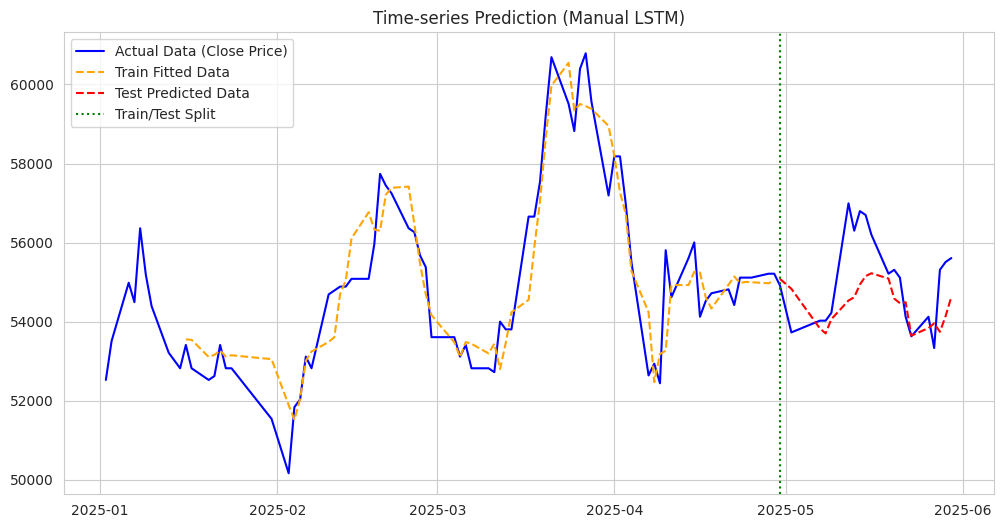

In [ ]:
actual_close = df['Close'].values

train_pred_plot = np.empty_like(actual_close)
train_pred_plot[:] = np.nan

train_pred_plot[seq_length : train_size + seq_length] = train_predicted

test_pred_plot = np.empty_like(actual_close)
test_pred_plot[:] = np.nan

test_pred_plot[train_size + seq_length :] = test_predicted


## 시각화
plt.figure(figsize=(12, 6))

plt.plot(df.index, actual_close, label='Actual Data (Close Price)', color='blue')
plt.plot(df.index, train_pred_plot, label='Train Fitted Data', color='orange', linestyle='--')
plt.plot(df.index, test_pred_plot, label='Test Predicted Data', color='red', linestyle='--')

# 훈련/테스트 분리선
split_idx = train_size + seq_length
if split_idx < len(df.index):
    plt.axvline(x=df.index[split_idx], c='green', linestyle=':', label='Train/Test Split')
else:
    print(f"Split index {split_idx} is out of bounds for df.index (length {len(df.index)})")


plt.title('Time-series Prediction using LSTM')
plt.legend()
plt.show()

여기까지가 LSTM을 이용한 주가 예측이었습니다!

## GRU (Gated Recurrent Unit)

GRU는 LSTM을 좀 더 단순화한 모델입니다. $c_t$ (셀 상태)가 따로 없고, 2개의 게이트만 사용합니다.

<img src='https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdna%2FcWUO6M%2FbtqOSxbT285%2FAAAAAAAAAAAAAAAAAAAAAEpjlo7q0u8szumdLmyDJnwwVzuMnoBdl86og-bkJC2g%2Fimg.png%3Fcredential%3DyqXZFxpELC7KVnFOS48ylbz2pIh7yKj8%26expires%3D1764514799%26allow_ip%3D%26allow_referer%3D%26signature%3DLodzb83GtERU6X0SOrlaZKVU7Dk%253D'>

- Reset Gate ($r_t$): '과거 정보'($h_{t-1}$)를 얼마나 무시할지 결정.

- Update Gate ($z_t$): '과거'($h_{t-1}$)와 '현재'($\tilde{h}_t$) 정보의 비중을 결정 (LSTM의 Forget/Input 게이트를 하나로 합친 역할).

- $h_t = (1-z_t) \odot h_{t-1} + z_t \odot \tilde{h}_t$

### GRU (nn.GRU) 직접 구현하기


In [ ]:
class MyGRU(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, batch_first=True):
        '''
        input_size: 입력 피처의 차원
        hidden_size: 은닉 상태의 차원
        num_layers: 쌓아 올릴 GRU 레이어의 수
        batch_first: 입력 텐서의 첫 번째 차원이 배치 크기인지 여부 (True: [batch, seq, feature])
        '''

        super(MyGRU, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.batch_first = batch_first

        # GRU 레이어들의 가중치(Linear)를 저장할 리스트
        self.layers = nn.ModuleList()

        for i in range(num_layers):
            # 현재 레이어의 입력 크기
            # 첫 번째 레이어(i==0)는 'input_size', 이후는 이전 층의 'hidden_size'가 됩니다
            current_input_size = input_size if i == 0 else ***********

            # GRU는 3가지 연산(Reset, Update, New Candidate)이 필요합니다
            # 1. Input-to-Hidden (r, z, n 3개 게이트에 대한 가중치)
            # (W_ir, W_iz, W_in) 3개에 대한 가중치를 3*hidden_size로 한 번에 정의
            self.layers.append(nn.Linear(current_input_size, 3 * self.hidden_size))

            # 2. Hidden-to-Hidden (r, z, n 3개 게이트에 대한 가중치)
            # 3*hidden_size로 한 번에 정의
            self.layers.append(nn.Linear(self.hidden_size, 3 * self.hidden_size))


    def forward(self, x, init_state=None):
        device = x.device

        # batch_first=True (입력이 [batch, seq, feature])인 경우 데이터를 전치해줍니다
        if self.batch_first:
            batch_size, seq_len, _ = x.shape
            x = x.*********(0, 1)
        else:
           # batch_first=False (입력이 [seq, batch, feature])인 경우
            seq_len, batch_size, _ = x.shape

        # --- 초기 은닉 상태(h_0) 설정 ---
        if init_state is None:
            # GRU는 LSTM과 달리 Cell State(c_t)가 없고 Hidden State(h_t)만 있습니다.
            # (num_layers, batch_size, hidden_size) 크기의 0텐서 생성
            h_prev_layers = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(device)
        else:
            # 제공된 초기 은닉 상태 사용
            h_prev_layers = init_state

        last_layer_outputs = []

        # Time Step별 반복
        for t in range(seq_len):
            x_t = x[t, :, :]
            current_input = x_t
            h_current_layers = []

            # 레이어(깊이)별 반복
            for l in range(self.num_layers):
                h_prev = h_prev_layers[l] # (t-1)의 은닉 상태

                i2h = self.layers[l*2]
                h2h = self.layers[l*2 + 1]

                # GRU 게이트 계산
                # (W_i * x_t) - 3개 게이트의 Input-to-Hidden 부분
                gates_input = i2h(current_input)
                # (W_h * h_{t-1}) - 3개 게이트의 Hidden-to-Hidden 부분
                gates_hidden = h2h(h_prev)

                i_r, i_z, i_n = gates_input.chunk(3, 1)
                h_r, h_z, h_n = gates_hidden.chunk(3, 1)

                # reset, update 게이트는 시그모이드, new 게이트는 tanh를 사용해주세요!
                # r_t (Reset Gate): '과거 정보'($h_{t-1}$)를 얼마나 무시할지 결정
                r_t = torch.*******(i_r + h_r)
                # z_t (Update Gate): '과거'($h_{t-1}$)와 '현재'($n_t$) 정보의 비중을 결정
                z_t = torch.*******(i_z + h_z)
                # n_t (New/Candidate Gate): '새로운 후보' 정보
                n_t = torch.****(i_n + (r_t * h_n)) # New (Candidate) Gate

                # 은닉 상태 업데이트
                # (z_t: 얼마나 잊을지) * (n_t: 새 정보) + (z_t: 얼마나 기억할지) * (h_prev: 이전 정보)
                h_t = (1 - z_t) * *** + z_t * ******

                # 현재 time step 't'의, 'l'번째 레이어 h_t 저장
                h_current_layers.append(h_t)
                # 'l'번째 레이어의 출력(h_t)이 (l+1)번째 레이어의 입력(current_input)이 됨
                current_input = h_t

            h_prev_layers = torch.stack(h_current_layers)
            last_layer_outputs.append(h_t)

        out = torch.stack(last_layer_outputs)
        if self.batch_first:
            out = out.transpose(0, 1)

        return out, h_prev_layers

### GRU 모델 만들기

In [ ]:
class SimpleGRU(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length):
        super(SimpleGRU, self).__init__()
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length

        # 위에서 만든 MyGRU 클래스를 사용해 줍니다
        self.gru = *****(input_size=input_size, hidden_size=hidden_size,
                             num_layers=num_layers, batch_first=True)

        self.fc_1 =  nn.Linear(hidden_size, 128)
        self.fc = nn.Linear(128, num_classes)
        self.relu = nn.ReLU()

    def forward(self,x):

        h_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        output, hn = self.gru(x, h_0)

        out = output[:, -1, :]
        out = self.relu(out)
        out = self.fc_1(out)
        out = self.relu(out)
        out = self.fc(out)
        return out

### 모델 정의 & 학습

In [ ]:
num_epochs = 500
lr = 0.0001

input_size = 4
hidden_size = 64
num_layers = 1

num_classes=1

# SimpleGRU 모델을 사용합니다
model = *********(num_classes, input_size, hidden_size, num_layers, X_train_tensors_f.shape[1])

# 위와 동일하게 평균제곱오차로 평가, 옵티마이저는 Adam으로 설정해주세요
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [ ]:
# gpu로 모델 옮기기

model = model.to(device)
X_train_tensors_f = X_train_tensors_f.to(device)
y_train_tensors = y_train_tensors.to(device)
X_test_tensors_f = X_test_tensors_f.to(device)
y_test_tensors = y_test_tensors.to(device)

In [ ]:
for epoch in range(num_epochs) :
    outputs = model.forward(X_train_tensors_f)
    optimizer.zero_grad()
    loss = criterion(outputs, y_train_tensors)
    loss.backward()

    optimizer.step()
    if epoch % 100 == 0 :
        print(f'Epoch : {epoch}, loss : {loss.item():1.5f}')

Epoch : 0, loss : 0.37029
Epoch : 100, loss : 0.03854
Epoch : 200, loss : 0.01386
Epoch : 300, loss : 0.00830
Epoch : 400, loss : 0.00651


In [ ]:
model.eval()

with torch.no_grad():
    train_predict = model(X_train_tensors_f)
    test_predict = model(X_test_tensors_f)

train_predict_cpu = train_predict.cpu().numpy()
y_train_cpu = y_train_tensors.cpu().numpy()
test_predict_cpu = test_predict.cpu().numpy()
y_test_cpu = y_test_tensors.cpu().numpy()

train_predicted = ms.inverse_transform(train_predict_cpu)
train_label_y = ms.inverse_transform(y_train_cpu)
test_predicted = ms.inverse_transform(test_predict_cpu)
test_label_y = ms.inverse_transform(y_test_cpu)

print(f"Train predicted shape: {train_predicted.shape}")
print(f"Test predicted shape: {test_predicted.shape}")

Train predicted shape: (69, 1)
Test predicted shape: (20, 1)


### 결과 시각화

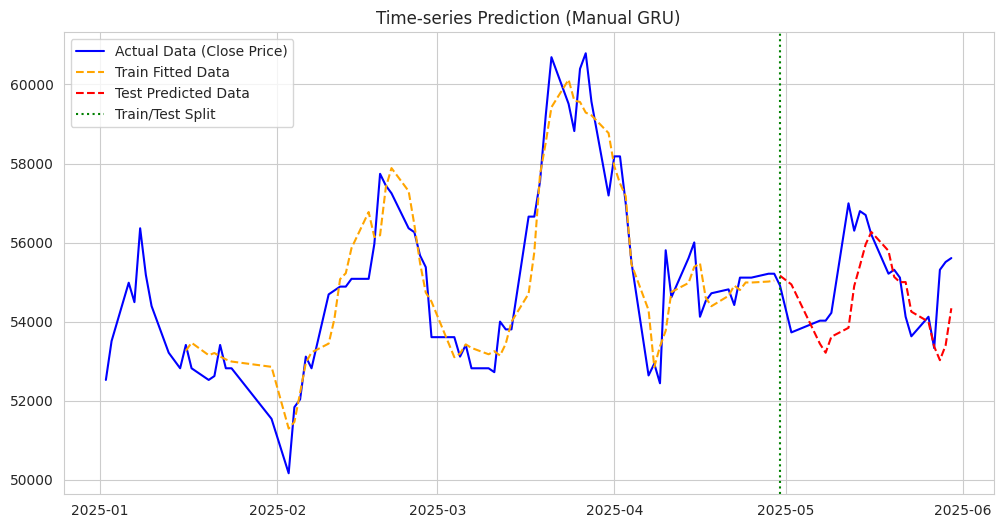

In [ ]:
actual_close = df['Close'].values

train_pred_plot = np.empty_like(actual_close)
train_pred_plot[:] = np.nan
train_pred_plot[seq_length : train_size + seq_length] = train_predicted

test_pred_plot = np.empty_like(actual_close)
test_pred_plot[:] = np.nan
test_pred_plot[train_size + seq_length :] = test_predicted


plt.figure(figsize=(12, 6))
plt.plot(df.index, actual_close, label='Actual Data (Close Price)', color='blue')
plt.plot(df.index, train_pred_plot, label='Train Fitted Data', color='orange', linestyle='--')
plt.plot(df.index, test_pred_plot, label='Test Predicted Data', color='red', linestyle='--')

split_idx = train_size + seq_length
if split_idx < len(df.index):
    plt.axvline(x=df.index[split_idx], c='green', linestyle=':', label='Train/Test Split')
else:
    print(f"Split index {split_idx} is out of bounds for df.index (length {len(df.index)})")


plt.title('Time-series Prediction (Manual GRU)')
plt.legend()
plt.show()

# 오늘 실습은 여기까지입니다~ <br> 고생하셨습니다!